# Benchmark code
https://www.kaggle.com/code/sungkeum/eda-and-lr-random-forest-accuracy-86

* Linear Regression from the link above as baseline
* RandomForestRegression as the benchmark

In [68]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('./data/encoded_data.csv')
seed = 1  # for reproducibility

In [69]:
response = 'Price'
df.dropna(inplace=True)
df.shape
X = df.drop([response], axis=1)
y = df[response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

X_trainTotal = pd.concat([X_train, X_val], axis=0)
y_trainTotal = pd.concat([y_train, y_val], axis=0)

# Scale the data
scaler = StandardScaler()
X_trainTotal_scaled = scaler.fit_transform(X_trainTotal)
#X_val = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## The tuned model

In [70]:
results_df = pd.read_csv('./data/model_results.csv', index_col=0)
best_model = results_df['R2'].idxmax()
parameter_alpha = results_df.loc[best_model, 'Parameter alpha']
parameter_l1_ratio = results_df.loc[best_model, 'Parameter l1_ratio']
print(f"The best model is {best_model} with alpha={parameter_alpha} and l1_ratio={parameter_l1_ratio}")
results_df

The best model is Ridge Regression with alpha=0.9 and l1_ratio=nan


,R2,Parameter alpha,Parameter l1_ratio
Ridge Regression,0.690956,0.9,NaN
Lasso Regression,0.658773,20.0,NaN
ElasticNet using Grid search,0.543226,0.1,0.9
ElasticNet using Randomized search,0.454146,1.6,0.7


In [71]:
ridge = Ridge(alpha=parameter_alpha)
ridge.fit(X_trainTotal, y_trainTotal)

Ridge(alpha=0.9)

In [72]:
# predict
y_ridge_train_pred = ridge.predict(X_trainTotal)
y_ridge_test_pred = ridge.predict(X_test)

In [73]:
# validate
ridge_train_mse = mean_squared_error(y_trainTotal, y_ridge_train_pred)
ridge_train_r2 = r2_score(y_trainTotal, y_ridge_train_pred)

ridge_test_mse = mean_squared_error(y_test, y_ridge_test_pred)
ridge_test_r2 = r2_score(y_test, y_ridge_test_pred)

In [74]:
ridge_results = pd.DataFrame(['Fine tuned ridge regression', ridge_train_mse, ridge_train_r2, ridge_test_mse, ridge_test_r2]).transpose()
ridge_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2']

ridge_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Fine tuned ridge regression,233814357.470608,0.705766,235081830.170333,0.688802


## Linear Regression as baseline

In [75]:
# set and train the model
lr = LinearRegression()
lr.fit(X_trainTotal, y_trainTotal)

LinearRegression()

In [76]:
# predict
y_lr_train_pred = lr.predict(X_trainTotal)
y_lr_test_pred = lr.predict(X_test)

In [77]:
# validate
lr_train_mse = mean_squared_error(y_trainTotal, y_lr_train_pred)
lr_train_r2 = r2_score(y_trainTotal, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [78]:
lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2']

lr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,227445624.328417,0.713781,248077942.673056,0.671597


## Random Forest Regression as benchmark

In [79]:
# set and train the model
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_trainTotal_scaled, y_trainTotal)

RandomForestRegressor(random_state=1)

In [80]:
# predict
y_rf_train_pred = rf.predict(X_trainTotal_scaled)
y_rf_test_pred = rf.predict(X_test_scaled)

In [81]:
rf_train_mse = mean_squared_error(y_trainTotal, y_rf_train_pred)
rf_train_r2 = r2_score(y_trainTotal, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

In [82]:
rf_results = pd.DataFrame(['Random Forest Regression', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2']

rf_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random Forest Regression,18107300.843765,0.977214,79121813.25243,0.89526


## Protected attribute


In [83]:
sensitive_data = X_trainTotal.filter(like='State_').columns
sensitive_data
X_train_filtered = X_trainTotal.drop(sensitive_data, axis=1)
X_test_filtered = X_test.drop(sensitive_data, axis=1)

In [90]:
ridge = Ridge(alpha=parameter_alpha)
ridge.fit(X_train_filtered, y_trainTotal)
# predict
y_ridge_train_filtered_pred = ridge.predict(X_train_filtered)
y_ridge_test_filtered_pred = ridge.predict(X_test_filtered)
# validate
ridge_train_mse = mean_squared_error(y_trainTotal, y_ridge_train_filtered_pred)
ridge_train_r2 = r2_score(y_trainTotal, y_ridge_train_filtered_pred)
ridge_test_mse = mean_squared_error(y_test, y_ridge_test_filtered_pred)
ridge_test_r2 = r2_score(y_test, y_ridge_test_filtered_pred)

filtered_results = pd.DataFrame(['Filtered data (geographical bias)', ridge_train_mse, ridge_train_r2, ridge_test_mse, ridge_test_r2]).transpose()
filtered_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2']

filtered_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Filtered data (geographical bias),234320205.974071,0.70513,234897090.572794,0.689046


As one can see the overall accuracy is not impacted by the presence or absence of the geographically sensitive columns. This might be due to the fact, that for sensitive reasons the city names were already removed in the data preparation section. The reason for the elimination of city names was, that this information might negatively impact poorer regions, towns compared to rich towns. Our assumption was, that leaving poorer, less developed town names in the geographical information might have ensured a more accurate regression but on the cost of social and geographical bias. But as we wanted to eliminate (or at least dampen) any kind of geographical and social bias, we decided to ignoring the town names and including just the wider geographical information, the state names. Our aim was achieved as the town is not significantly impacting the results anymore. This meets our expactations as the indirect effect of richer or poorer regions is not influencing the car prices.

## Overview

In [91]:
overviews = pd.concat([lr_results, ridge_results, rf_results, filtered_results], axis=0)
overviews

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,227445624.328417,0.713781,248077942.673056,0.671597
0,Fine tuned ridge regression,233814357.470608,0.705766,235081830.170333,0.688802
0,Random Forest Regression,18107300.843765,0.977214,79121813.25243,0.89526
0,Filtered data (geographical bias),234320205.974071,0.70513,234897090.572794,0.689046


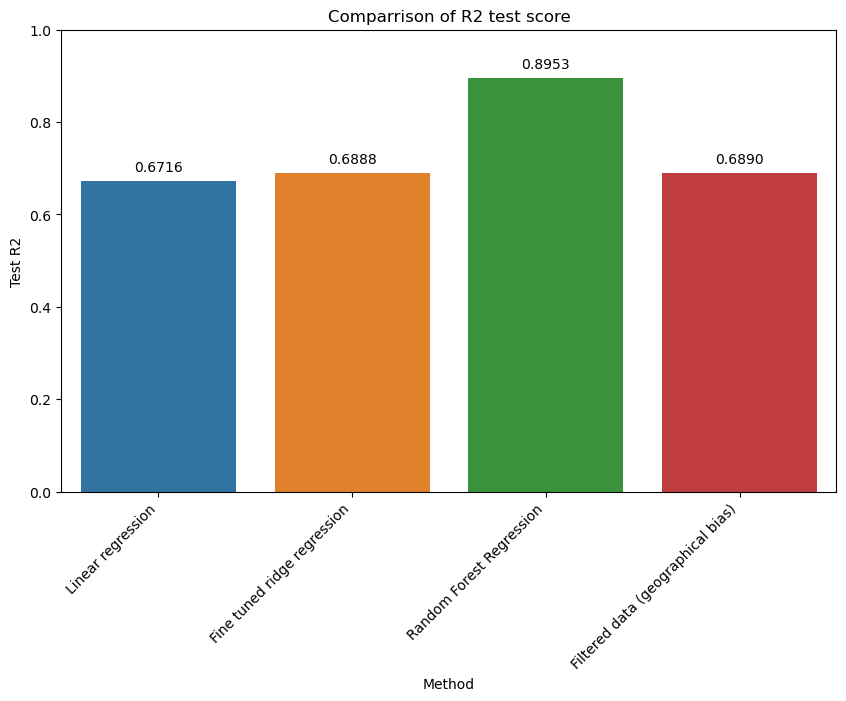

In [92]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = overviews["Method"] , y=overviews["Test R2"])
ax.set(ylim=(0, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Comparrison of R2 test score')
plt.savefig('./diagrams/final_results.png')
plt.show()